In [38]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as smp
import plotly.graph_objects as go
from scipy import constants
import random


# Define the parameters of the basic simulation


class KleinNishina:
    """Class for simulating Compton scattering using the Klein-Nishina equation."""
    
    def __init__(self, E, no_of_points=10000):
        """Initialize the Klein-Nishina simulator with the incident photon energy E."""
        self.E = E
        self._calculate_distribution(no_of_points)
    
    def _calculate_distribution(self, no_of_points):
        """Calculate the cumulative distribution function for scattering angles."""
        alp = (self.E * constants.e) / (constants.electron_mass * constants.c**2)
        r_e = 2.8179403262e-15  # Classical electron radius
        
        theta, alpha = smp.symbols('theta alpha', real=True, positive=True)
        dsdo = r_e / 2 * (1 + smp.cos(theta)**2) / (1 + alpha * (1 - smp.cos(theta)))**2 * \
               (1 + alpha**2 * (1 - smp.cos(theta))**2 / ((1 + smp.cos(theta)**2) * (1 + alpha * (1 - smp.cos(theta)))))
        dsdt = 2 * smp.pi * dsdo * smp.sin(theta)
        dsdt = dsdt.simplify()
        s = smp.integrate(dsdt, (theta, 0, smp.pi)).simplify().simplify()
        pdf_omega = dsdo / s
        pdf_omega = pdf_omega.simplify()
        pdf_omega_f = smp.lambdify([theta, alpha], pdf_omega)
        
        self.the = np.linspace(0, np.pi, no_of_points)
        self.pdf_o = pdf_omega_f(self.the, alp)
        self.cdf_o = np.cumsum(self.pdf_o) / np.sum(self.pdf_o)  # Normalize CDF
    
    def calc_scattering_angles(self):
        """Calculate scattering angles based on the Klein-Nishina distribution."""
        rand_o = np.random.rand()
        i = np.argmin(np.abs(self.cdf_o - rand_o))
        polar = self.the[int(i)]
        azimuthal = np.random.rand() * 2 * np.pi
        return  polar, azimuthal
   # def angle_x(self, polar):
        # x = np.rad2deg(self.the[i])
        # y = np.rad2deg(polar)
       # z = 180 -(x+y)
       # return z
    def angle_with_x_axis(self, polar, azimuthal):
        """
        Calculating the angle made by the scattered gamma photon with the x-axis.
        Parameters: polar : θ in radians, Azimuthal: φ in radians.
        Returns: The angle with the x-axis in radians.
        """
        x = np.sin(polar) * np.cos(azimuthal)
        y = np.sin(polar) * np.sin(azimuthal)
        z = np.cos(polar)
        magnitude = np.sqrt(x**2 + y**2 + z**2)
        cos_alpha = x / magnitude
        alpha = np.arccos(cos_alpha)
        return alpha
        


In [39]:
def electron_energy(E, angle_deg):
    """
    Calculate the kinetic energy of the recoiling electron after Compton scattering.
    """
    mec2 = 0.511  # Rest mass energy of the electron in MeV
    angle_rad = np.radians(angle_deg)
    E_prime = E / (1 + (E / mec2) * (1 - np.cos(angle_rad))) #E_prime = energy after scattering
    Ke = E - E_prime #  Ke = energy of the recoiling electron
    return Ke

In [40]:
def generate_source_points(num_sources, dimension, shape_type=None, x_min=-4, x_max=44, y_min=-4, y_max=44, radius=10, distance=10):
    source_positions = []

    if dimension == '3D':
        for _ in range(num_sources):
            angle = random.uniform(0, 2 * np.pi)
            elevation = (-1,-300) # the range of z axis
            x = round(random.uniform(x_min, x_max), 2)
            y = round(random.uniform(y_min, y_max), 2)
            z = round(distance * np.sin(elevation), 2)
            source_positions.append([x, y, z])
    elif dimension == '2D':
        # Initialize empty arrays for points
        x_points = np.array([])
        y_points = np.array([])
         
        if shape_type == 'ring':
            # Generate points on the perimeter of a circle
            angles = np.linspace(0, 2 * np.pi, num_sources)
            x_points = radius * np.cos(angles)
            y_points = radius * np.sin(angles)
            
        elif shape_type == 'circle':
            # Generate points to cover the entire area of a circle
            angles = np.random.uniform(0, 2 * np.pi, num_sources)
            radii = np.sqrt(np.random.uniform(0, radius**2, num_sources))
            x_points = radii * np.cos(angles)
            y_points = radii * np.sin(angles)
            
        elif shape_type == 'square':
            # Generate points to cover the entire area of a square
            x_points = np.random.uniform(x_min, x_max, num_sources)
            y_points = np.random.uniform(y_min, y_max, num_sources)
            
        elif shape_type == 'random':
            # Generate random points in 2D plane at z = 0
            x_points = np.random.uniform(x_min, x_max, num_sources)
            y_points = np.random.uniform(y_min, y_max, num_sources)
            
        else:
            raise ValueError("Invalid shape_type. Choose 'ring', 'circle', 'square', or 'random'.")
        
        # Randomly translate the points to a position within the plane limits
        if shape_type in ['ring', 'circle']:
            x_center = np.random.uniform(x_min + radius, x_max - radius)
            y_center = np.random.uniform(y_min + radius, y_max - radius)
            x_points += x_center
            y_points += y_center
        
        # Add points to source positions with z = 0
        source_positions = list(zip(np.round(x_points, 2), np.round(y_points, 2), np.full(num_sources, -200)))

    else:
        raise ValueError("Invalid dimension. Choose '2D' or '3D'.")

    return source_positions

In [41]:
# take a point in continuous space and map it to 
# the center of the nearest detector element within a detector grid. Each detector element is a square of a specified size.

def map_to_detector(point, detector_size):
    return (point // detector_size) * detector_size + detector_size / 2


In [44]:
# Create an instance of the Klein-Nishina class - get a probability distribution
# to get angles from.
source_energy = 1000000 # eV
kn = KleinNishina(source_energy)
num_sources = 10000
dimension = '2D'
shape_type = 'random'
x_min, x_max = 0, 40
y_min, y_max = 0, 40
radius = 5
n_photons = 100
source_pos = generate_source_points(num_sources, dimension,shape_type, x_min, x_max, y_min, y_max, radius)
#print(source_pos)
scatter_x = np.linspace(4, 44, 100)
scatter_y = np.linspace(4, 44, 100)
scatter_x, scatter_y = np.meshgrid(scatter_x, scatter_y)
scatter_z = 0 * scatter_x  # Plane in xy at z = 0

absorber_x = np.linspace(0, 48, 100)
absorber_y = np.linspace(0, 48, 100)
absorber_x, absorber_y = np.meshgrid(absorber_x, absorber_y)
absorber_z = 0 * absorber_x + 100  # Plane in xy at z = 100

# Create figure
fig = go.Figure()
# create a function
# Create grid lines for scatter plane
scatter_grid_lines = []
grid_size_scatter = 2
for i in range(4, 45, grid_size_scatter):
    scatter_grid_lines.append(go.Scatter3d(
        x=[i, i], y=[4, 44], z=[0, 0],
        mode='lines', line=dict(color='rgb(255,182,193)', width=1), showlegend=False
    ))
    scatter_grid_lines.append(go.Scatter3d(
        x=[4, 44], y=[i, i], z=[0, 0],
        mode='lines', line=dict(color='rgb(255,182,193)', width=1), showlegend=False
    ))

# Create grid lines for absorption plane
absorption_grid_lines = []
grid_size_absorption = 6
for i in range(0, 49, grid_size_absorption):
    absorption_grid_lines.append(go.Scatter3d(
        x=[i, i], y=[0, 48], z=[100, 100],
        mode='lines', line=dict(color='gray', width=1), showlegend=False
    ))
    absorption_grid_lines.append(go.Scatter3d(
        x=[0, 48], y=[i, i], z=[100, 100],
        mode='lines', line=dict(color='gray', width=1), showlegend=False
    ))
######################################
# Add the grid lines to the figure
fig.add_traces(scatter_grid_lines)
fig.add_traces(absorption_grid_lines)

# Plot scatterer plane
fig.add_trace(go.Surface(x=scatter_x, y=scatter_y, z=scatter_z, opacity=0.7, showscale=False))

# Plot absorber plane
fig.add_trace(go.Surface(x=absorber_x, y=absorber_y, z=absorber_z, opacity=0.7, showscale=False))

# Plot source
for pos in source_pos:
    fig.add_trace(go.Scatter3d(x=[pos[0]], y=[pos[1]], z=[pos[2]], mode='markers', marker=dict(color='green'), name='Source'))

# Create arrays for the positions of hits on the 1st set of detectors
scat_pos = np.zeros((n_photons, 3))
absorb_pos = np.zeros((n_photons, 3))
thetas = []
azimuths = []
source_events = {}
use_mapped = False
for pos in source_pos:
    source_key = tuple(pos)
    source_events[source_key] = []
    event_count = 0
    for i in range(n_photons):
        if event_count >= 3:
            break        
        scat_pos = [int(random.uniform(4, 44)), int(random.uniform(4, 44)), 0]
        scat_pos_mapped = [map_to_detector(scat_pos[0], 2), map_to_detector(scat_pos[1], 2), scat_pos[2]]
        angles = kn.calc_scattering_angles()
        theta = angles[0]
        azimuth = angles[1]
        #unmapped remove comment
        #absorb_pos = [int[scat_pos[0]+ (100/np.cos(theta))* np.sin(theta) * np.cos(azimuth), scat_pos[1] + (100/np.cos(theta)) * np.sin(theta) * np.sin(azimuth),- 100]]
        #comment the below for unmapped data
        
        if use_mapped:
            # Calculate absorb position using mapped scatter position
            absorb_x = scat_pos_mapped[0] + (100/np.cos(theta)) * np.sin(theta) * np.cos(azimuth)
            absorb_y = scat_pos_mapped[1] + (100/np.cos(theta)) * np.sin(theta) * np.sin(azimuth)
            absorb_pos = [absorb_x, absorb_y, 100]

            if 0 <= absorb_pos[0] <= 48 and 0 <= absorb_pos[1] <= 48:
                absorb_pos_mapped = [map_to_detector(absorb_pos[0], 6), map_to_detector(absorb_pos[1], 6), absorb_pos[2]]
                e_energy = electron_energy(source_energy, theta)
                data_point = np.concatenate((scat_pos_mapped, absorb_pos_mapped, [theta], [e_energy]))
        else:
            # Calculate absorb position using unmapped scatter position
            absorb_pos = [int(scat_pos[0] + (100/np.cos(theta)) * np.sin(theta) * np.cos(azimuth)),
                          int(scat_pos[1] + (100/np.cos(theta)) * np.sin(theta) * np.sin(azimuth)),
                          100]

            if 0 <= absorb_pos[0] <= 48 and 0 <= absorb_pos[1] <= 48:
                e_energy = electron_energy(source_energy, theta)
                data_point = np.concatenate((scat_pos, absorb_pos, [theta], [e_energy]))
        thetas.append(theta)
        azimuths.append(azimuth)
        absorb_x = scat_pos_mapped[0] + (100/np.cos(theta))* np.sin(theta) * np.cos(azimuth)
        absorb_y = scat_pos_mapped[1] + (100/np.cos(theta)) * np.sin(theta) * np.sin(azimuth)
        absorb_pos = [absorb_x, absorb_y, 100]        
        # Check if absorb_pos is within the bounds of the absorption plane
        if 0 <= absorb_pos[0] <= 48 and 0 <= absorb_pos[1] <= 48:
            absorb_pos_mapped = [map_to_detector(absorb_pos[0], 6), map_to_detector(absorb_pos[1], 6), absorb_pos[2]]
            e_energy = electron_energy(source_energy, theta)
            #to plot mapped
            data_point = np.concatenate((scat_pos_mapped, absorb_pos_mapped, [theta], [e_energy]))
            #to plot unmapped
            #data_point = np.concatenate((absorb_pos, scat_pos, [theta], [e_energy]))
            event_count += 1
            source_events[source_key].append(data_point)
            thetas.append(theta)
            azimuths.append(azimuth)
            # Plot scatterer to source line
            #fig.add_trace(go.Scatter3d(x=[pos[0], scat_pos_mapped[0]], y=[pos[1], scat_pos_mapped[1]], z=[pos[2], scat_pos_mapped[2]], mode='lines', line=dict(color='blue')))
            #plot scatter to absorber line
            #fig.add_trace(go.Scatter3d(x=[scat_pos_mapped[0], absorb_pos_mapped[0]], y=[scat_pos_mapped[1], absorb_pos_mapped[1]], z=[scat_pos_mapped[2], absorb_pos_mapped[2]], mode='lines', line=dict(color='red')))

#plot_histogram(np.rad2deg(thetas))
#plot_histogram(np.rad2deg(azimuths))

# Set layout
#fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'), title='Interactive Simulation')

# Show plot
#fig.show()
####


In [35]:
''' 
1. Create a folder for event simulation.
2. Create python files for important functions (klein nishina and source generation)
3. Create a class of User functions and include plotting functions and saving functions
4. Optimize the number of parameters in a function for source and for detecter space. #needs to be done

'''

' \n1. Create a folder for event simulation.\n2. Create python files for important functions (klein nishina and source generation)\n3. Create a class of User functions and include plotting functions and saving functions\n4. Optimize the number of parameters in a function for source and for detecter space. #needs to be done\n\n'

In [45]:
first_5_source_keys = list(source_events.keys())[:5]
for source_key in first_5_source_keys:
    events = source_events[source_key]
    print(f"Source Position: {source_key}")
    print("Events:")
    for event in events:
        print(event)


Source Position: (2.95, 19.83, -200)
Events:
[1.70000000e+01 3.90000000e+01 0.00000000e+00 9.00000000e+00
 3.30000000e+01 1.00000000e+02 6.09529928e-02 5.25475520e+05]
[9.00000000e+00 1.50000000e+01 0.00000000e+00 9.00000000e+00
 3.00000000e+00 1.00000000e+02 1.09338358e-01 7.80858930e+05]
[7.00000000e+00 5.00000000e+00 0.00000000e+00 1.50000000e+01
 3.00000000e+00 1.00000000e+02 6.91219506e-02 5.87473125e+05]
Source Position: (3.33, 17.73, -200)
Events:
[2.90000000e+01 3.70000000e+01 0.00000000e+00 4.50000000e+01
 2.70000000e+01 1.00000000e+02 1.74061639e-01 9.00303628e+05]
[3.90000000e+01 2.70000000e+01 0.00000000e+00 2.70000000e+01
 4.50000000e+01 1.00000000e+02 2.06737470e-01 9.27215498e+05]
[5.00000000e+00 1.10000000e+01 0.00000000e+00 3.30000000e+01
 2.10000000e+01 1.00000000e+02 2.76173612e-01 9.57865562e+05]
Source Position: (36.67, 27.43, -200)
Events:
[5.00000000e+00 9.00000000e+00 0.00000000e+00 9.00000000e+00
 3.00000000e+00 1.00000000e+02 8.32605314e-02 6.73868354e+05]
[3.

In [46]:
import pandas as pd

data = []
#flattening to save as csv
for source_key, events in source_events.items():
    for event in events:
        data.append([source_key[0], source_key[1], source_key[2], *event])

columns = ["Source_X", "Source_Y", "Source_Z", "Scatter_X", "Scatter_Y", "Scatter_Z", "Absorb_X", "Absorb_Y", "Absorb_Z", "Theta", "Energy"]
df = pd.DataFrame(data, columns=columns)

# Define the CSV file name
csv_file_name = "source_events.csv"

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)

print(f"Data has been saved to {csv_file_name}")



Data has been saved to source_events.csv


In [21]:
import pandas as pd
# Convert data to a DataFrame
columns = ['source_x', 'source_y', 'source_z', 'absorb_x', 'absorb_y', 'absorb_z', 
           'scat_x', 'scat_y', 'scat_z', 'theta', 'e_energy']
df = pd.DataFrame(source_events, columns=columns)

# Save DataFrame to CSV
df.to_csv('scattering_data.csv', index=False)

In [25]:
import matplotlib.pyplot as plt
def plot_histogram(scatter_angles):
    plt.hist(scatter_angles, bins=30, edgecolor='black')
    plt.xlabel('Scatter Angle (degrees)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Scatter Angles')
    plt.show()


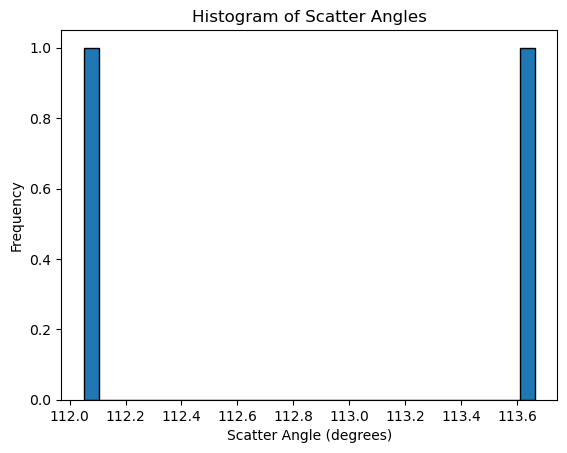

In [26]:
scatter_angles = kn.calc_scattering_angles()
scatter_angles = np.rad2deg(scatter_angles)
plot_histogram(scatter_angles)
